# Study for jitter effect in Energy resolution 

for tessim-simulated files under different:

* sampling rates
* BBFB (yes/no)

**stochastic + nobbfb = NO JITTER**

**stochastic + bbfb = JITTER**

**non-stochastic + bbfb = JITTER**

In [1]:
# ----IMPORT MODULES --------------
from __future__ import print_function
from __future__ import division
from multiprocessing import Pool, cpu_count
from itertools import repeat
from subprocess import check_call, check_output,STDOUT
from cycler import cycler
from astropy.io import fits
import math
import sys, os
import shutil, tempfile, shlex
import re
import warnings
import numpy as np
from numpy.polynomial import Polynomial
import auxpy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

cwd = os.getcwd()
tmpDir = tempfile.mkdtemp()
os.environ["PFILES"] = tmpDir + ":" + os.environ["PFILES"]
os.environ["HEADASNOQUERY"] = ""
os.environ["HEADASPROMPT"] = "/dev/null/"


# Define auxiliary functions

In [2]:
def recentre_offset(arrPhaseInit, Ymag, arrmethod, bbfb):
        """
        For a plot Ymag vs arrPhase, this function recentre the offset
        to get a smooth function  (~ parabola) for later fit
        Used for previous offsets (not in use now)
            :param arrPhase: 1D array with calculated offset (X axis)
            :param Ymag: 1D array with relevant magnitude for each offset
            :param arrmethod: integer in [0-4] to select which offset has been calculated in arrivalPhase func
            :param bbfb: "" if no BBFB and "bbfb" if BBFB is used
        """    
        # If arrivalPhase1 or arrivalPhse2: (should be identical, apart from rounding errors...)
        #             differences are calculated from non-jitter(simulated) times => if >1, subtract 1
        #
        # If arrivalPhase3: 
        #             differences are calculated from closest sample
        #
        # If arrivalPhase4: 
        #             differences are calculated from previous sample
        #
        #
        #   arrPhase                non-stoch                               stoch+bbfb
        #   ========         ============================          =================================
        #     1/2               if >1, subtract 1                        (if >1, subtract 1) &
        #                                                              offsets largest than minimum
        #                                                             energy error must be moved to 
        #                                                              the left branch =>dome shape (~ -0.5-0.5)
        #
        #     3             Inconsistent low-high energies               ok - dome shape  (~ -0.5-0.5)
        #                           
        #                                         
        #
        #     4             offsets largest than maximum             offsets largest than minimum
        #                   energy error must be moved to            energy error must be moved to 
        #                         the left branch                            the left branch (~ -0.5-0.5)
        #
        #

        #
        # For arrivalPhase3/4, offsets largest than maximum energy error must be moved to the left branch

        imax = np.argmax(Ymag)
        imin = np.argmin(Ymag)
        
        arrPhase = np.array(arrPhaseInit)

        maxval = arrPhase[imax]
        minval = arrPhase[imin]
        
        if imax == imin:
            maxval = Ymag
            minval = Ymag
            
        # Correction only applicable if arrmethod== 1 or 2 (only possible larger than 1 offsets):
        for j in range(0,arrPhase.size):
            if arrPhase[j] > 1:
                arrPhase[j] -= np.floor(arrPhase[j])

        if bbfb == "" and arrmethod == 4:
            # print("Modifying offsets at ", arrPhase[imax])
            for j in range(0,arrPhase.size):
                if arrPhase[j] > maxval:
                    arrPhase[j] -= 1
        elif bbfb == "" and arrmethod == 3:
            print("Error: arrival method=3 gives inconsistent curves for different energies")
            raise
        elif bbfb == "bbfb" and arrmethod in (1,2,4):
            for j in range(0,arrPhase.size):
                if arrPhase[j] > minval:
                    arrPhase[j] -= 1
        return arrPhase

In [3]:
def tsdf(commToRun,tesF):
    """
    Function to be used by python 'pool' for large simulations
    Run simulation command for individual file and depurate tessim file
    :param commToRun : command to run tessim simulation
    :param tesF: simulation file (to remove last/first row)
    """
    try:
        args = shlex.split(commToRun)
        check_call(args, stderr=STDOUT)
    except RuntimeError:
        print("Error running tool for tessim list generation")
        raise
        
    # update HISTORY
    auxpy.updateHISTORY(tesF, commToRun)
    # rm first (and LAST) record and update NETTOT
    fsim = fits.open(tesF)
    nrows = fsim[1].header["NAXIS2"]
    assert nrows > 1, "Tessim failed: just one huge row present!"
    fsim.close()
    
    try:
        print("Removing first & last row, just in case, and updating NETTOT")
        auxpy.rmLastAndFirst(tesF, 1)
    except RuntimeError:
        print("Error running FTOOLS to remove initial & last rows in ", tesF)
        raise


In [4]:
def fit_2D_gain_scale(ph_values,phase_values,energy_list,deg=6,show=False):
    '''Fits a 2D gain scale giving the energy as a function of ph and phase (by PP)
    
    Arguments:
        - ph_values: 2D array of the measured PH values
        - phase_values: 2D array of the measured phase values
        - energy_list: 1D array of the simulated energies
        - deg: degree of the polynom to fit (in both X and Y)
        - show: option to plot the results
    '''
    ph_values = np.array(ph_values)
    phase_values = np.array(phase_values)
    energies = np.array([energy_list for _ in range(len(ph_values[0]))]).transpose()
    poly_coeffs = polyfit2d(ph_values, phase_values, energies, [deg,deg])
    return poly_coeffs

def polyfit2d(x, y, f, deg):
    x = np.asarray(x)
    y = np.asarray(y)
    f = np.asarray(f)
    deg = np.asarray(deg)
    vander = np.polynomial.polynomial.polyvander2d(x, y, deg)
    #print(vander.size)
    #print(vander)
    vander = vander.reshape((-1,vander.shape[-1]))
    f = f.reshape((vander.shape[0],))
    c = np.linalg.lstsq(vander, f)[0]
    return c.reshape(deg+1)

# Define variables 

In [5]:
#      Simulation options to calculate jitter correction
# ========================================================
noise = "nonoise" # "" or "nonoise"
jitter = "jitter" # "" or "jitter"
stoch = "" # "stoch" for stochastic simulator or "nostoch" for new tessim with no stochastic
bbfb = "bbfb" # "" for not_bbfb or "bbfb" for dobbfb in tessim 
smprt = "" # or "samprate2"
npulsesLib = 20000 # number of pulses for libraries
npulsesGain = 20000 # number of pulses for gainScale
singleSeparation = 40000
preBufferSize = 1000
triggerSizeTC = 1000 + 2*singleSeparation + 1000

eurecaDir = "/dataj6/ceballos/INSTRUMEN/EURECA"
sixteDir = eurecaDir + "/testHarness/simulations/SIXTE"
pairsDir = eurecaDir + "/ERESOL/PAIRS"
impDir = pairsDir + "/PIXIMPACT"
ereDir = pairsDir + "/eresolLPA2shunt"
tesDir = pairsDir + "/tessimLPA2shunt"

pixtype = "'file:/dataj6/ceballos/INSTRUMEN/EURECA/testHarness/simulations/SIXTE/newpix_full.fits[LPA2shunt]'"
coeffsfile = ereDir + "/coeffs_polyfit.dat"
eners_keV = (0.2, 0.5, 1, 2, 3, 4, 5, 6, 7, 8)
calibEnergies = [0.2, 0.5, 1, 2, 3, 4, 5, 6, 7, 8]
libEnergies = (6,)
eners_keV = (1, 2, 3, 4, 5, 6, 7, 8)
test_keV = (1,2,3,4,5,6,7,)

# samprate
smprtStr = ""
if smprt == "samprate2":
    smprtStr = "_samprate2"
    samprate = 78125. # Hz
    pulseLength = 4096
    nSamples = 4096
    largeFilter = 4096
    nSgms = 6
    samplesUp = 2
    samplesDown = 3
else:
    samprate = 156250. # Hz
    pulseLength = 8192
    nSamples = 8192
    largeFilter = 8192
    nSgms = 5
    samplesUp = 3
    samplesDown = 3

npulses = 1000 # number of pulses for curve/surface creation (nonoise)
tpulses = 2000 # number of pulses for test of FWHM (noisy)

xmlfile = eurecaDir + "/ERESOL/xifu_detector_hex_baselineNEWgrades" + smprtStr + ".xml"    
expos = '{0:0.0f}'.format(npulses/2. * triggerSizeTC/float(samprate))
triggerSizeTS = preBufferSize + pulseLength + 1000
triggerTS3val = triggerSizeTS - preBufferSize
texpos = '{0:0.0f}'.format(tpulses/2. * triggerSizeTC/float(samprate))
    
# jitter
jitterStr = ""
offset = 0
if jitter == "jitter":
    jitterStr = "_jitter"
    offset = -1
#noise
noiseStr = ""
simnoise = "y"
if noise == "nonoise":
    noiseStr = "_nonoise"
    simnoise = "n"
#stoch 
stochStr = ""
stochastic = " stochastic_integrator=n"
if jitter == "jitter":
    stochastic = ""
if stoch == "stoch":
    stochStr = "_stoch"
    stochastic = " stochastic_integrator=y"
#bbfb
bbfbStr = ""
dobbfb = " dobbfb=n"
if jitter == "jitter":
    dobbfb = ""
if bbfb == "bbfb":
    bbfbStr = "_bbfb"
    dobbfb = " dobbfb=y carrier_frequency = 20e6 bbfb_delay = 40 decimation_filter = y"

# check consistency among simulation options
if jitter == "jitter" and stoch == "stoch" and bbfb == "":
    raise ValueError("Jitter is not possible with stoch & noBBFB")
#elif stoch == "" and bbfb == "bbfb":
#    raise ValueError("BBFB is not possible without stoch")
elif stoch == "stoch" and bbfb == "":
    warnings.warn("Stochastic simulation but no jitter will be generated!")

# define optimized colors for offset plots
cols = [(165,0,38),(215,48,39),(244,109,67),(253,174,97),(254,224,144),(224,243,248),(171,217,233),(116,173,209),
        (69,117,180),(49,54,149)]
reversed_cols = cols[::-1]
for i in range(0,len(cols)):
        cols[i] = tuple(round((x/255.),2) for x in reversed_cols[i])
        # print("Color=", cols[i])



# ... and filenames

In [6]:
# a) Filenames for surface fitting and dependency curves (nonoise)
# ========================================================
impFs = list()
imp0Fs = list()
evtFs = list()
calibFs = list()
tesFs = list()
impForNoise = "forNoise" + str(pulseLength) + "samples_tessimLPA2shunt_100s_pairscps_ADC" + smprtStr + ".piximpact"
forNoiseFile = ("forNoise" + str(pulseLength) + "samples_tessimLPA2shunt_100s_pairscps_ADC" +
                smprtStr + stochStr + bbfbStr + ".fits")
noiseFile = "noise" + str(pulseLength) + "samples_tessimLPA2shunt_B0_ADC" + smprtStr + stochStr + bbfbStr + ".fits"
#libfile = (sixteDir + "/LIBRARIES/tessimLPA2shunt/GLOBAL/ADC/libraryMultiE_GLOBAL_PL" + str(pulseLength) + "_" +
#           str(npulsesLib) + "p" + jitterStr + noiseStr + stochStr + bbfbStr + ".fits")
libfile = (sixteDir + "/LIBRARIES/tessimLPA2shunt/GLOBAL/ADC/library6keV_PL" + str(pulseLength) + "_" +
           str(npulsesLib) + "p" + smprtStr + jitterStr + noiseStr + stochStr + bbfbStr + ".fits")

for i in range(0,len(eners_keV)):
    file = (impDir + "/sep40000sam_" + str(expos) + "s_" + str(eners_keV[i]) + "keV" +
            smprtStr + jitterStr + "_trSz82000.piximpact")
    impFs.append(file)
   
    file = (impDir + "/sep40000sam_" + str(expos) + "s_" + str(eners_keV[i]) + "keV" +
            smprtStr + "_trSz82000.piximpact")
    imp0Fs.append(file)
    
    file = (tesDir + "/sep40000sam_" + str(npulses) + "p_" + str(eners_keV[i]) + "keV" +
            smprtStr + jitterStr + noiseStr + stochStr + bbfbStr + ".fits")
    tesFs.append(file)
    
    file = (ereDir + "/events_sep40000sam_" + str(npulses) + "p_SIRENA" + str(pulseLength)+ "_pL" +
            str(pulseLength) + "_" + str(eners_keV[i]) + "keV_STC_F0F_fixedlib6OF_OPTFILT" + 
            str(pulseLength) + smprtStr + jitterStr + noiseStr + stochStr + bbfbStr + ".fits")
    evtFs.append(file)

    file = (ereDir + "/events_sep40000sam_" + str(npulses) + "p_SIRENA" + str(pulseLength)+ "_pL" +
            str(pulseLength) + "_" + str(eners_keV[i]) + "keV_STC_F0F_fixedlib6OF_OPTFILT" + 
            str(pulseLength) + smprtStr + jitterStr + noiseStr + stochStr + bbfbStr + ".calib")
    calibFs.append(file)

# a) Filenames for test (noisy)
# =============================
test_impFs = list()
test_tesFs = list()
test_evtFs = list()
test_calibFs = list()
tnoiseStr = ""
tnpulsesLib = 20000
    
tlibfile = (sixteDir + "/LIBRARIES/tessimLPA2shunt/GLOBAL/ADC/library6keV_PL" + str(pulseLength) + "_" +
           str(tnpulsesLib) + "p" + smprtStr + jitterStr + tnoiseStr + stochStr + bbfbStr + ".fits")

for i in range(len(test_keV)):
    file = (impDir + "/sep40000sam_" + str(texpos) + "s_" + str(test_keV[i]) + "keV" +
            smprtStr + jitterStr + "_trSz82000.piximpact")
    test_impFs.append(file)
    file = (tesDir + "/sep40000sam_" + str(tpulses) + "p_" + str(test_keV[i]) + "keV" +
            smprtStr + jitterStr + tnoiseStr + stochStr + bbfbStr + ".fits")
    test_tesFs.append(file)
    file = (ereDir + "/events_sep40000sam_" + str(tpulses) + "p_SIRENA" + str(pulseLength)+ "_pL" +
            str(pulseLength) + "_" + str(test_keV[i]) + "keV_STC_F0F_fixedlib6OF_OPTFILT" + 
            str(pulseLength) + smprtStr + jitterStr + tnoiseStr + stochStr + bbfbStr + ".fits")
    test_evtFs.append(file)
    file = (ereDir + "/events_sep40000sam_" + str(tpulses) + "p_SIRENA" + str(pulseLength)+ "_pL" +
            str(pulseLength) + "_" + str(test_keV[i]) + "keV_STC_F0F_fixedlib6OF_OPTFILT" + 
            str(pulseLength) + smprtStr + jitterStr + tnoiseStr + stochStr + bbfbStr + ".calib")
    test_calibFs.append(file)



# Pre-processing: noise file, library, gain scale coefficients

## 1. Create Noise file

In shell:

```
> python simulNoise.py --pixName=LPA2shunt --stoch=stoch --bbfb=bbfb --jitter=jitter
            --pulseLength=8192 --space=ADC --simTime=100 --pixel=1
```

Since stochastic simulations need a large amount of time, noise files creation is done in 10 parallel processes. Tessim is run first so that only the "forNoise*" files are created. Then all of them are merged with "fmerge" and then the noise spectrum file is created.

In [1]:
#auxpy.simulNoise(pixName='LPA2shunt', samprate=smprt, jitter=jitter,
#                 stoch=stoch, bbfb=bbfb, pulseLength=pulseLength,
#                 space='ADC', acbias='yes', scaleFactor=0, samplesUp=2, nSgms=5,
#                 nintervals=1000, simTimeN=100, pixel=1, preBufferSize=1000)

## 2. Create Library file

Create libfile = sixteDir + /LIBRARIES/tessimLPA2shunt/GLOBAL/ADC/libraryMultiE_GLOBAL_PL(pulseLength)_(npulsesLib)p_(jitterStr)(noiseStr)(stochStr).fits


In [2]:
run = 0
if run:
    ## Create library: template files + multiE library
    print("Creating library of ",npulsesLib,"pulses for:")
    print("jitter=",jitter,"noise=",noise,"bbfb=",bbfb,"samprate=",smprtStr)
    #sys.exit()
    # Create library: template files + multiE library
    auxpy.simulLibsGlobal(pixName='LPA2shunt', space='ADC',
                        samprate=smprt, jitter=jitter,
                        noise=noise, stoch=stoch,
                        bbfb=bbfb, pulseLength=pulseLength,
                        largeFilter=pulseLength,
                        libEnergies=libEnergies,
                        nsamples=nSamples, acbias='yes',
                        nSimPulses=npulsesLib, createLib=1, 
                        tstartPulse1All=[0,0,0,0,0,0,0,0,0,0],
                        noiseMat='no', weightMat='no',
                        pixel=1, preBufferSize=1000, separation=40000)


## 3. Calculate GAINSCALE

### 3.1 . Simulate single files (in gainScales dir)

Run in shell (for each energy of calibration):
```
> python simulSingles.py --pixName=LPA2shunt --monoEnergy=0.2 --samprate=smprt --jitter=jitter
--noise=noise --stoch=stoch
```

and then, move files to tessimLPA2shunt/gainScale dir.

Or...

In [3]:
# simulate single files for GainScale
run = 0
#auxpy.simulSingles(pixName='LPA2shunt', monoEkeV=mono, acbias='yes',
#                       samprate=smprt, jitter=jitter, noise=noise,
#                       stoch=stoch, bbfb=bbfb, nSimPulses=npulsesGain, 
#                       singleSeparation=singleSeparation, pixel=1,
#                       preBufferSize=1000, pulseLength=pulseLength)
if run:
    print("Creating GAIN SCALE ",npulsesLib,"pulses for:")
    print("jitter=",jitter,"noise=",noise,"bbfb=",bbfb,"samprate=",smprtStr)
    # optimize for multicore: run simulation in parallel
    nproc = cpu_count()
    #print("nproc=",nproc)
    with Pool(processes=nproc) as pool:
        pool.starmap(auxpy.simulSingles, zip(repeat('LPA2shunt'), calibEnergies,
                                             repeat('y'),repeat(smprt),repeat(jitter),
                                             repeat(noise),repeat(stoch),repeat(bbfb),
                                             repeat(npulsesGain), repeat(singleSeparation),
                                             repeat(1), repeat(1000), repeat(pulseLength)))
    pool.close()
    pool.join()
    
    for mono in calibEnergies: 
        singleFile = ("sep" + str(singleSeparation) + "sam_" + str(npulsesGain) + "p_" + 
                      str(mono) + "keV" + smprtStr + jitterStr + noiseStr + stochStr + ".fits")
        shutil.move((tesDir + "/" + singleFile), (tesDir + "/gainScale/" + singleFile))
#sys.exit()

### 3.2 . Reconstruct single files

Run in shell to get also json files with FWHM for reconstructed (not calibrated) energies
```
> source /dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/runCompareACDCpy.csh 1
```

### 3.3. Get GAINSCALE from R script: polyfit2Bias.R

This will create the coefficients file (*/dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/PAIRS/eresolLPA2shunt/coeffs_polyfit.dat*):

```
"METHODS" "ALIAS" "a0" "a1" "a2" "a3" "a4"
"OPTIMAL FILTERING (fixed OF 6keV filter samprate) STC, nonoise" "STC_fixedlib6OF_OPTFILT8192_jitter_nonoise" 0.00245024600675378 1.2539667770017 -0.0492489724547103 0.00118023200208777 0
"OPTIMAL FILTERING (fixed OF 6keV filter samprate) STC, nonoise, stoch, bbfb" "STC_fixedlib6OF_OPTFILT8192_jitter_nonoise_stoch_bbfb" 0.000154277251777552 1.25883695701217 -0.0523367084509556 0
.00178137217747703 -3.62793675936531e-05
```



# Create data files for surface fitting (NONOISE)

PIXIMPACT -> TESSIM -> SIRENA(STC) -> CALIBRATED


In [10]:
run = 0
# 1) Create Piximpact file nonoise, jitter, stoch, bbfb
# ==========================================================
if run:
    for i in range(0,len(eners_keV)):
        comm0 = ("tesconstpileup PixImpList=" + imp0Fs[i] + " XMLFile=" + xmlfile + " timezero=0 tstop=" + str(expos) +
                 " energy=" + str(eners_keV[i]) + " offset=0 pulseDistance=" + str(singleSeparation) +
                 " TriggerSize=" + str(triggerSizeTC) + " clobber=yes")
        print(comm0)
        try:
            args = shlex.split(comm0)
            check_call(args, stderr=STDOUT)
        except:
            print("Error running tool for piximpact (no jitter) list generation")
            os.chdir(cwd)
            shutil.rmtree(tmpDir)
            raise
        #print("Created ", imp0Fs[i])

        comm = ("tesconstpileup PixImpList=" + impFs[i] + " XMLFile=" + xmlfile + " timezero=0 tstop=" +
                str(expos) + " energy=" + str(eners_keV[i]) + " offset=" + str(offset) + " pulseDistance=" +
                str(singleSeparation) + " TriggerSize=" + str(triggerSizeTC) + " clobber=yes")
        print(comm)
        try:
            args = shlex.split(comm)
            #check_call(args, stderr=STDOUT)
        except:
            print("Error running tool for piximpact list generation")
            os.chdir(cwd)
            shutil.rmtree(tmpDir)
            raise
        print("Created ", impFs[i])
    print("########################")        
    print("PIXIMPACT/0 files created")
    print("########################")        
#sys.exit()

In [11]:
run = 0
# 2) Create tessimfile nonoise, jitter, stoch, bbfb
# ===========================================================================
# Create individual commands for each simulation and use 'pool' for multicore
comms = []
if run:
    for i in range(0,len(eners_keV)):
        streamFile = "events_" + str(eners_keV[i]) + ".stream"
        command = ("tessim PixID=1 PixImpList=" + impFs[i] + " Streamfile=" + tesFs[i] + 
                   " tstart=0. tstop=" + str(expos) +  " clobber=yes" +
                   " triggerSize=" + str(triggerSizeTS) + " preBuffer=1000 " +
                   " triggertype='diff:3:20:" + str(triggerTS3val) + "'" +
                   " sample_rate=" + str(samprate) + " PixType=" + pixtype +
                   " doCrosstalk=n simnoise=n" + stochastic + dobbfb)
        comms.append(command)

    # optimize for multicore: run simulation in parallel
    nproc = cpu_count()
    #print("nproc=",nproc)
    with Pool(processes=nproc) as pool:
        pool.starmap(tsdf, zip(comms, tesFs))
    pool.close()
    pool.join()

    print("########################")        
    print("TESSIM files created")            
    print("########################")  
#sys.exit()

In [12]:
run = 0
# 3) Run SIRENA (AD,STC)
# =======================
if run:
    print("Reconstructing",npulses, "single files with lib:", libfile)
    print("jitter=",jitter,"noise=",noise,"bbfb=",bbfb,"samprate=",smprtStr)
    #sys.exit()
    for i in range(0,len(eners_keV)):
        comm = ("tesreconstruction Recordfile=" + tesFs[i] + " TesEventFile=" + evtFs[i] + " Rcmethod=SIRENA" + 
                " PulseLength="+ str(pulseLength) + " LibraryFile=" + libfile +
                " samplesUp=3 nSgms=5 samplesDown=3 mode=1 OFLib=yes FilterDomain=F detectionMode=STC" +
                " FilterMethod=F0 clobber=yes EventListSize=1000 EnergyMethod=OPTFILT LagsOrNot=1" + 
                " XMLFile=" + xmlfile + " filtEeV=6000.0 OFStrategy=FIXED OFLength=" + str(pulseLength))
        try:
            #print(comm)
            args = shlex.split(comm)
            check_call(args, stderr=STDOUT)
        except:
            print("Error running tool for SIRENA reconstruction with command:\n", comm)
            shutil.rmtree(tmpDir)
            raise
    print("########################")        
    print("SIRENA files created")            
    print("########################")        
#sys.exit()

In [13]:
run = 0
# 4) Correct energies from gain scale
if run: 
    print("Correcting",npulses, "pulses single files with lib:", libfile)
    print("jitter=",jitter,"noise=",noise,"bbfb=",bbfb,"samprate=",smprtStr)
    for i in range(0,len(eners_keV)):
        alias = "STC_fixedlib6OF_OPTFILT" + str(pulseLength) + smprtStr + jitterStr + noiseStr + stochStr + bbfbStr
        comm = ("python convertEnergies.py --inFile=" + evtFs[i] + " --outFile=" + calibFs[i] + 
                " --coeffsFile=" + coeffsfile + " --alias=" + alias)
        try:
            args = shlex.split(comm)
            check_call(args, stderr=STDOUT)
        except:
            print("Error running tool for GAIN SCALE calibration with comm=")
            print(comm)
            shutil.rmtree(tmpDir)
            raise

    print("########################")        
    print("CALIBRATED files created")            
    print("########################")        
#sys.exit()

# Create test Files (noisy): piximpact, tessim, uncalE, calE

In [14]:
run = 0
if run:
    print("Creating PIXIMPACT test files for BBFB,SAMPRATE=",bbfb,smprt)
    # 1) Create Piximpact file jitter
    # ==================================
    for i in range(len(test_keV)):
        comm = ("tesconstpileup PixImpList=" + test_impFs[i] + " XMLFile=" + xmlfile + 
                " timezero=0 tstop=" + str(texpos) + " energy=" + str(test_keV[i]) +
                " offset=" + str(offset) + " pulseDistance=" + str(singleSeparation) +
                " TriggerSize=" + str(triggerSizeTC) + " clobber=yes")
        try:
            args = shlex.split(comm)
            check_call(args, stderr=STDOUT)
        except:
            print("Error running tool for piximpact list generation")
            os.chdir(cwd)
            raise
    print("########################")        
    print("PIXIMPACT files created")            
    print("########################") 

In [15]:
# 2) Create tessim file noisy + jitter, stoch, bbfb
# ==========================================================
# Create individual commands for each simulation
run = 0
comms = []
if run:
    print("Creating TESSIM test files for BBFB,SAMPRATE=",bbfb,smprt)
    for i in range(0,len(test_keV)):
        command = ("tessim PixID=1 PixImpList=" + test_impFs[i] + " Streamfile=" + test_tesFs[i] + 
                   " tstart=0. tstop=" + str(texpos) +  " clobber=yes" +
                   " triggerSize=" +str(triggerSizeTS) + " preBuffer=" + str(preBufferSize) +
                   " triggertype='diff:3:20:" + str(triggerTS3val) + "'" +
                   " sample_rate=" + str(samprate) + " PixType=" + pixtype +
                   " doCrosstalk=n simnoise=y" + stochastic + dobbfb)
        comms.append(command)

    # optimize for multicore: run simulation in parallel
    nproc = cpu_count()
    print("nproc=",nproc)
    with Pool(processes=nproc) as pool:
        pool.starmap(tsdf, zip(comms, tesFs))
    pool.close()
    pool.join()
    
    print("########################")        
    print("TESSIM files created")            
    print("########################") 


In [16]:
run = 0
# 3) Run SIRENA (AD,STC)
# =======================
if run:
    print("Creating SIRENA test files for BBFB=","SAMPRATE=",smprt,"and libfile=", tlibfile)
    for i in range(0,len(test_keV)):
        comm = ("tesreconstruction Recordfile=" + test_tesFs[i] + " TesEventFile=" + test_evtFs[i] +
                " Rcmethod=SIRENA" + " PulseLength=" + str(pulseLength) + " LibraryFile=" + tlibfile +
                " samplesUp=3 nSgms=5 samplesDown=3 mode=1 OFLib=yes FilterDomain=F detectionMode=STC" +
                " FilterMethod=F0 clobber=yes EventListSize=1000 EnergyMethod=OPTFILT LagsOrNot=1" +
                " XMLFile=" + xmlfile + " filtEeV=6000.0 OFStrategy=FIXED OFLength=" + str(pulseLength))
        try:
            print(comm)
            args = shlex.split(comm)
            check_call(args, stderr=STDOUT)
        except RuntimeError:
            print("Error running tool for SIRENA reconstruction with command:")
            print(comm)
            raise
    print("########################")        
    print("test SIRENA files created")            
    print("########################")   

In [17]:
run=0
if run:
    print("Creating CALIB test files for BBFB,SAMPRATE=",bbfb,smprt)
    # 4) Correct energies from gain scale
    # =======================
    for i in range(0,len(test_keV)):
        alias = "STC_fixedlib6OF_OPTFILT" + str(pulseLength) + smprtStr + jitterStr + tnoiseStr + stochStr + bbfbStr
        comm = ("python convertEnergies.py --inFile=" + test_evtFs[i] + " --outFile=" + test_calibFs[i] + 
                " --coeffsFile=" + coeffsfile + " --alias=" + alias)
        try:
            #print("Running comm=", comm)
            args = shlex.split(comm)
            check_call(args, stderr=STDOUT)
        except:
            print("Error running tool for GAIN SCALE calibration")
            shutil.rmtree(tmpDir)
            raise
    print("##################################")
    print("TEST Files created and calibrated")
    print("##################################")

Creating CALIB test files for BBFB,SAMPRATE= bbfb 
##################################
TEST Files created and calibrated
##################################


#  Reconstructed Energy vs Arrival Phase (NONOISE)

## a) Plot curves

Plotting nonoise curves for nCpulses= 997  noise= nonoise samprate= 156250.0 bbfb


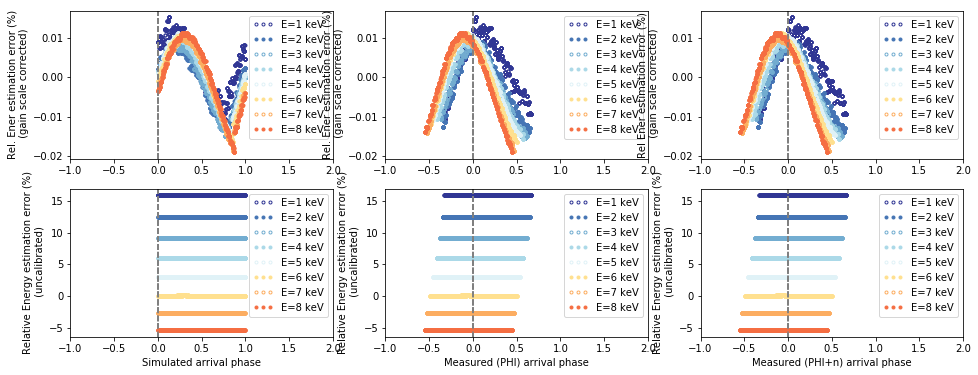

In [18]:
# Find number of pulses (after cleaning of tessim files)
npls = list()

for i in range(0,len(eners_keV)):
    uncal = fits.open(evtFs[i], memmap=True)
    uncalTab = uncal[1].data
    npls.append(uncalTab.size)
    uncal.close()
nCpulses = np.amin(npls)
print("Plotting nonoise curves for nCpulses=",nCpulses," noise=",noise, "samprate=",samprate, bbfb)

ph_values = np.zeros((len(eners_keV),nCpulses))
phcorr_values = np.zeros((len(eners_keV),nCpulses))
Phase0_values = np.zeros((len(eners_keV),nCpulses))
PHI_values = np.zeros((len(eners_keV),nCpulses))
PHIn_values = np.zeros((len(eners_keV),nCpulses))

for i in range(0,len(eners_keV)):
    # Impacts
    imp = fits.open(impFs[i], memmap=True)
    impTab = imp[1].data
    impTimes = impTab['TIME']
    impIDs = impTab['PH_ID']
    imp.close()

    # Detected events
    uncal = fits.open(evtFs[i], memmap=True)
    uncalTab = uncal[1].data
    uncalTimes = uncalTab['TIME']
    uncalEners = uncalTab['SIGNAL']
    ph_values[i,] = uncalEners[0:nCpulses]
    uncal.close()
    
    # Calibrated events
    cal = fits.open(calibFs[i], memmap=True)
    calTab = cal[1].data
    calTimes = calTab['TIME']
    calEners = calTab['SIGNAL']
    phcorr_values[i,] = calEners[0:nCpulses]
    cal.close()

    # look for energy string in name to get simulated energy
    srch = re.search('(?<=_)[0.]*[1-9](?=keV_STC)', calibFs[i])
    inkeV = float(srch.group(0))
    
    if inkeV != eners_keV[i]:
        print("Error: incompatible energies in input files:",inkeV,eners_keV[i])
        sys.exit()
    
    # arrival phases (see auxpy.py)
    # If arrivalPhase1 or arrivalPhse2: 
    #             differences are calculated from non-jitter(simulated) times => if >1, subtract 1
    #
    # If arrivalPhase3: 
    #             differences are calculated from closest sample
    #
    # If arrivalPhase4: 
    #             differences are calculated from previous sample
    #
    #
    #   arrPhase                non-stoch                               stoch+bbfb
    #   ========         ============================          =================================
    #     1/2               if >1, subtract 1                        (if >1, subtract 1) &
    #                                                              offsets largest than minimum
    #                                                             energy error must be moved to 
    #                                                              the left branch =>dome shape (~ -0.5-0.5)
    #
    #     3             Inconsistent low-high energies               ok - dome shape  (~ -0.5-0.5)
    #                           
    #                                         
    #
    #     4             offsets largest than maximum             offsets largest than minimum
    #                   energy error must be moved to            energy error must be moved to 
    #                         the left branch                            the left branch (~ -0.5-0.5)
    #
    #
    
    #
    # For arrivalPhase3/4, offsets largest than maximum energy error must be moved to the left branch
    #
    # energy errors
    relErr = (calEners - inkeV)*100./inkeV  # [%] Relative Energy Estimation Error
    relErrUncal = (uncalEners - inkeV)*100./inkeV  # [%] Relative uncalEnergy Estimation Error
    
    arrPhase0 = auxpy.arrivalPhase(impF=impFs[i], evtF=evtFs[i],samprate=samprate, arrmethod=0)
    arrPhasePHI = auxpy.arrivalPhase(impF=impFs[i], evtF=evtFs[i],samprate=samprate, arrmethod=5)
    arrPhasePHIn = auxpy.arrivalPhase(impF=impFs[i], evtF=evtFs[i],samprate=samprate, arrmethod=6)
    #arrPhase2 = recentre_offset(arrPhaseInit, uncalEners, arrMeth, bbfb)    
    
    Phase0_values[i,] = arrPhase0[0:nCpulses]
    PHI_values[i,] = arrPhasePHI[0:nCpulses]
    PHIn_values[i,] = arrPhasePHIn[0:nCpulses]

fig = plt.figure(figsize=(16,6))

# Plot RelativeErrCorrEner vs Simulated Phases
ax = fig.add_subplot(231)
#ax.set_xlabel("Simulated arrival phase")
ax.set_ylabel("Rel. Ener estimation error (%)\n (gain scale corrected)")
for i in range(len(eners_keV)):
    inkeV = eners_keV[i]
    relErr = (phcorr_values[i,] - inkeV)*100./inkeV  # [%] Relative Energy Estimation Error
    labelLeg = "E=" + str(inkeV) + " keV"
    fc = cols[i]
    if i % 2 == 0:
        fc = 'none'
    ax.plot(Phase0_values[i,], relErr, marker='o', markerfacecolor=fc, linestyle='none', 
             markeredgecolor=cols[i], label=labelLeg, ms=3)
    ax.set_xlim(-1,2)
    ax.axvline(x=0, linestyle="dashed",color="gray")
    ax.legend(numpoints=3)
    
# Plot RelativeErrCorrEner vs PHI measured Phases
ax = fig.add_subplot(232)
#ax.set_xlabel("Measured (PHI) arrival phase")
ax.set_ylabel("Rel. Ener estimation error (%)\n (gain scale corrected)")
for i in range(len(eners_keV)):
    inkeV = eners_keV[i]
    relErr = (phcorr_values[i,] - inkeV)*100./inkeV  # [%] Relative Energy Estimation Error
    labelLeg = "E=" + str(inkeV) + " keV"
    fc = cols[i]
    if i % 2 == 0:
        fc = 'none'
    ax.plot(PHI_values[i,], relErr, marker='o', markerfacecolor=fc, linestyle='none', 
             markeredgecolor=cols[i], label=labelLeg, ms=3)
    ax.set_xlim(-1,2)
    ax.axvline(x=0, linestyle="dashed",color="gray")
    ax.legend(numpoints=3)
    
# Plot RelativeErrCorrEner vs Measured (PHI+n) Phases
ax = fig.add_subplot(233)
#ax.set_xlabel("Measured (PHI+n) arrival phase")
ax.set_ylabel("Rel Ener estimation error (%)\n (gain scale corrected)")
for i in range(len(eners_keV)):
    inkeV = eners_keV[i]
    relErr = (phcorr_values[i,] - inkeV)*100./inkeV  # [%] Relative Energy Estimation Error
    labelLeg = "E=" + str(inkeV) + " keV"
    fc = cols[i]
    if i % 2 == 0:
        fc = 'none'
    ax.plot(PHIn_values[i,], relErr, marker='o', markerfacecolor=fc, linestyle='none', 
             markeredgecolor=cols[i], label=labelLeg, ms=3)
    ax.set_xlim(-1,2)
    ax.axvline(x=0, linestyle="dashed",color="gray")
    ax.legend(numpoints=3)
    
# Plot RelativeErrUncorrEner vs Simulated Phases
ax = fig.add_subplot(234)
ax.set_xlabel("Simulated arrival phase")
ax.set_ylabel("Relative Energy estimation error (%)\n (uncalibrated)")
for i in range(len(eners_keV)):
    inkeV = eners_keV[i]
    relErr = (ph_values[i,] - inkeV)*100./inkeV  # [%] Relative Energy Estimation Error
    labelLeg = "E=" + str(inkeV) + " keV"
    fc = cols[i]
    if i % 2 == 0:
        fc = 'none'
    ax.plot(Phase0_values[i,], relErr, marker='o', markerfacecolor=fc, linestyle='none', 
             markeredgecolor=cols[i], label=labelLeg, ms=3)
    ax.set_xlim(-1,2)
    ax.axvline(x=0, linestyle="dashed",color="gray")
    ax.legend(numpoints=3)

    # Plot RelativeErrUncorrEner vs Measured (PHI) Phases
ax = fig.add_subplot(235)
ax.set_xlabel("Measured (PHI) arrival phase")
ax.set_ylabel("Relative Energy estimation error (%)\n (uncalibrated)")
for i in range(len(eners_keV)):
    inkeV = eners_keV[i]
    relErr = (ph_values[i,] - inkeV)*100./inkeV  # [%] Relative Energy Estimation Error
    labelLeg = "E=" + str(inkeV) + " keV"
    fc = cols[i]
    if i % 2 == 0:
        fc = 'none'
    ax.plot(PHI_values[i,], relErr, marker='o', markerfacecolor=fc, linestyle='none', 
             markeredgecolor=cols[i], label=labelLeg, ms=3)
    ax.set_xlim(-1,2)
    ax.axvline(x=0, linestyle="dashed",color="gray")
    ax.legend(numpoints=3)


# Plot RelativeErrCorrEner vs Corrected Phases
ax = fig.add_subplot(236)
ax.set_xlabel("Measured (PHI+n) arrival phase")
ax.set_ylabel("Relative Energy estimation error (%)\n (uncalibrated)")
for i in range(len(eners_keV)):
    inkeV = eners_keV[i]
    relErr = (ph_values[i,] - inkeV)*100./inkeV  # [%] Relative Energy Estimation Error
    labelLeg = "E=" + str(inkeV) + " keV"
    fc = cols[i]
    if i % 2 == 0:
        fc = 'none'
    ax.plot(PHIn_values[i,], relErr, marker='o', markerfacecolor=fc, linestyle='none', 
             markeredgecolor=cols[i], label=labelLeg, ms=3)
    ax.set_xlim(-1,2)
    ax.axvline(x=0, linestyle="dashed",color="gray")
    ax.legend(numpoints=3)

    

#    plt.plot(arrPhaseInit,relErr2, marker='o', markerfacecolor=fc, linestyle='none', 
#             markeredgecolor=cols[i], label=labelLeg, ms=3)
#    plt.xlim(-1,2)
#    plt.axvline(x=0, linestyle="dashed",color="gray")
#    plt.legend(numpoints=3)
#    #plt.show()
##plt.legend(numpoints=3)
#plt.xlabel("Measured arrival phase")
#plt.ylabel("Relative Energy estimation error (%)\n (gain scale corrected)")
#plt.show()


##  b) Plot 3D surfaces 

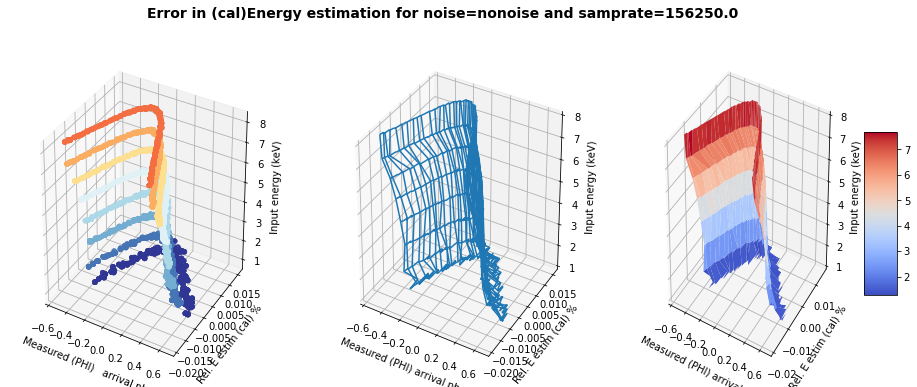

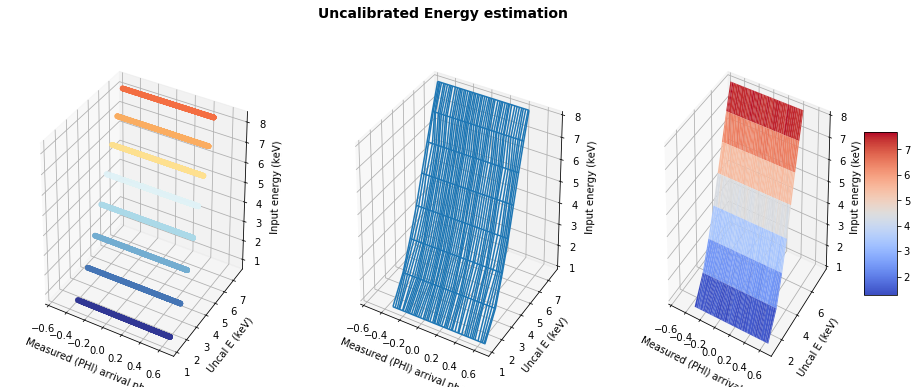

In [19]:
npts = len(PHI_values[1,])
X = np.zeros((len(eners_keV), npts))
Y = np.zeros((len(eners_keV), npts))
YS = np.zeros((len(eners_keV), npts))
Z = np.zeros((len(eners_keV), npts))

# PLOT      EcalibError  vs. offset  vs. Einput
# ==============================================
fig = plt.figure(figsize=(16,6))
suptitle='Error in (cal)Energy estimation for noise=' + noise + " and samprate=" + str(samprate)
fig.suptitle(suptitle, fontsize=14, fontweight='bold')

ax = fig.add_subplot(131, projection='3d')
ax.set_xlabel('Measured (PHI)   arrival phases')
ax.set_ylabel('Rel. E estim (cal) %')
ax.set_zlabel('Input energy (keV)')
for i in range(0,len(eners_keV)):
    X[i,] = PHI_values[i,]
    Y[i,] = (phcorr_values[i,]-eners_keV[i])*100./eners_keV[i]
    Z[i,] = np.repeat(eners_keV[i], npts)
    #XS[i,] = np.sort(X[i,],0)
    YS[i,] = [x for _,x in sorted(zip(X[i,],Y[i,]))]
    ax.scatter(xs=X[i,], ys=Y[i,], zs=eners_keV[i], zdir='z', s=20, c=cols[i], depthshade=True)
XS = np.sort(X,1)

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_wireframe(X=XS, Y=YS, Z=Z)
ax2.set_xlabel('Measured (PHI) arrival phases')
ax2.set_ylabel('Rel. E estim (cal) %')
ax2.set_zlabel('Input energy (keV)')

ax3 = fig.add_subplot(133, projection='3d')
surf = ax3.plot_surface(X=XS, Y=YS, Z=Z, cmap=cm.coolwarm, antialiased=True)
ax3.set_xlabel('Measured (PHI) arrival phases')
ax3.set_ylabel('Rel. E estim (cal) %')
ax3.set_zlabel('Input energy (keV)')
fig.colorbar(surf, shrink=0.5, aspect=5)

# PLOT      Euncalib  vs. offset  vs. Einput
# ===============================================
fig = plt.figure(figsize=(16,6))
fig.suptitle('Uncalibrated Energy estimation', fontsize=14, fontweight='bold')

ax = fig.add_subplot(131, projection='3d')
ax.set_xlabel('Measured (PHI) arrival phases')
ax.set_ylabel('Uncal E (keV)')
ax.set_zlabel('Input energy (keV)')
for i in range(0,len(eners_keV)):
    Y[i,] = ph_values[i,]
    YS[i,] = [x for _,x in sorted(zip(X[i,],Y[i,]))]
    ax.scatter(xs=X[i,], ys=Y[i,], zs=eners_keV[i], zdir='z', s=20, c=cols[i], depthshade=True)
XS = np.sort(X,1)

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_wireframe(X=XS, Y=YS, Z=Z)
ax2.set_xlabel('Measured (PHI) arrival phases')
ax2.set_ylabel('Uncal E (keV)')
ax2.set_zlabel('Input energy (keV)')

ax3 = fig.add_subplot(133, projection='3d')
surf = ax3.plot_surface(X=XS, Y=YS, Z=Z, cmap=cm.coolwarm, antialiased=True)
ax3.set_xlabel('Measured (PHI) arrival phases')
ax3.set_ylabel('Uncal E (keV)')
ax3.set_zlabel('Input energy (keV)')
fig.colorbar(surf, shrink=0.5, aspect=5)

# PLOT      Ecalib  vs. offset  vs. Einput
# ===============================================
#fig = plt.figure(figsize=(16,6))
#fig.suptitle('Calibrated Energy', fontsize=14, fontweight='bold')
#
#ax = fig.add_subplot(131, projection='3d')
#ax.set_xlabel('Corr arrival phases')
#ax.set_ylabel('Calib E (keV)')
#ax.set_zlabel('Input energy (keV)')
#for i in range(0,len(eners_keV)):
#    Y[i,] = phcorr_values[i,]
#    YS[i,] = [x for _,x in sorted(zip(X[i,],Y[i,]))]
#    ax.scatter(xs=X[i,], ys=Y[i,], zs=eners_keV[i], zdir='z', s=20, c=cols[i], depthshade=True)
#XS = np.sort(X,1)
#
#ax2 = fig.add_subplot(132, projection='3d')
#ax2.plot_wireframe(X=XS, Y=YS, Z=Z)
#ax2.set_xlabel('Corr arrival phases')
#ax2.set_ylabel('Calib E (keV)')
#ax2.set_zlabel('Input energy (keV)')
#
#ax3 = fig.add_subplot(133, projection='3d')
#surf = ax3.plot_surface(X=XS, Y=YS, Z=Z, cmap=cm.coolwarm, antialiased=True)
#ax3.set_xlabel('Corr arrival phases')
#ax3.set_ylabel('Calib E (keV)')
#ax3.set_zlabel('Input energy (keV)')
#fig.colorbar(surf, shrink=0.5, aspect=5)


# Fitting of a 2D polynomial to Unrecons vs Offsets

Based on PP functions. Functions input:

* Uncorr energies (ph_values): energies are reconstructed with a 50p library (jitter_nonoise)

* UnCorrected Arrival Phases (phase_values)

* Calibration Energies (energy_list)

In [20]:
print("Test of fitting")
print("Einput=", eners_keV[1])
print("phasecorr_values=",PHI_values[1,1])
print("phcorr_values=",phcorr_values[1,1])
print("ph_values=",ph_values[1,1])
coeffs=fit_2D_gain_scale(ph_values, PHI_values, eners_keV, deg=6, show=True)
#print(coeffs)
corrE = 0.
corrE = np.polynomial.polynomial.polyval2d(ph_values[1,1],PHI_values[1,1],coeffs)
print("corrE=", corrE)

Test of fitting
Einput= 2
phasecorr_values= 0.227121495995
phcorr_values= 2.00005358729
ph_values= 2.24886798143
corrE= 1.99998883746


# Test files energy corrections

Compare resconstructed energies @ 1keV and 7 keV before and after corrections.
For this, we use *tpulses* reconstructed with a *jitter_noisy* library using the coefficients calculated below.

Correcting energies for  2000 pulses with bbfb= bbfb and samprate= 156250.0


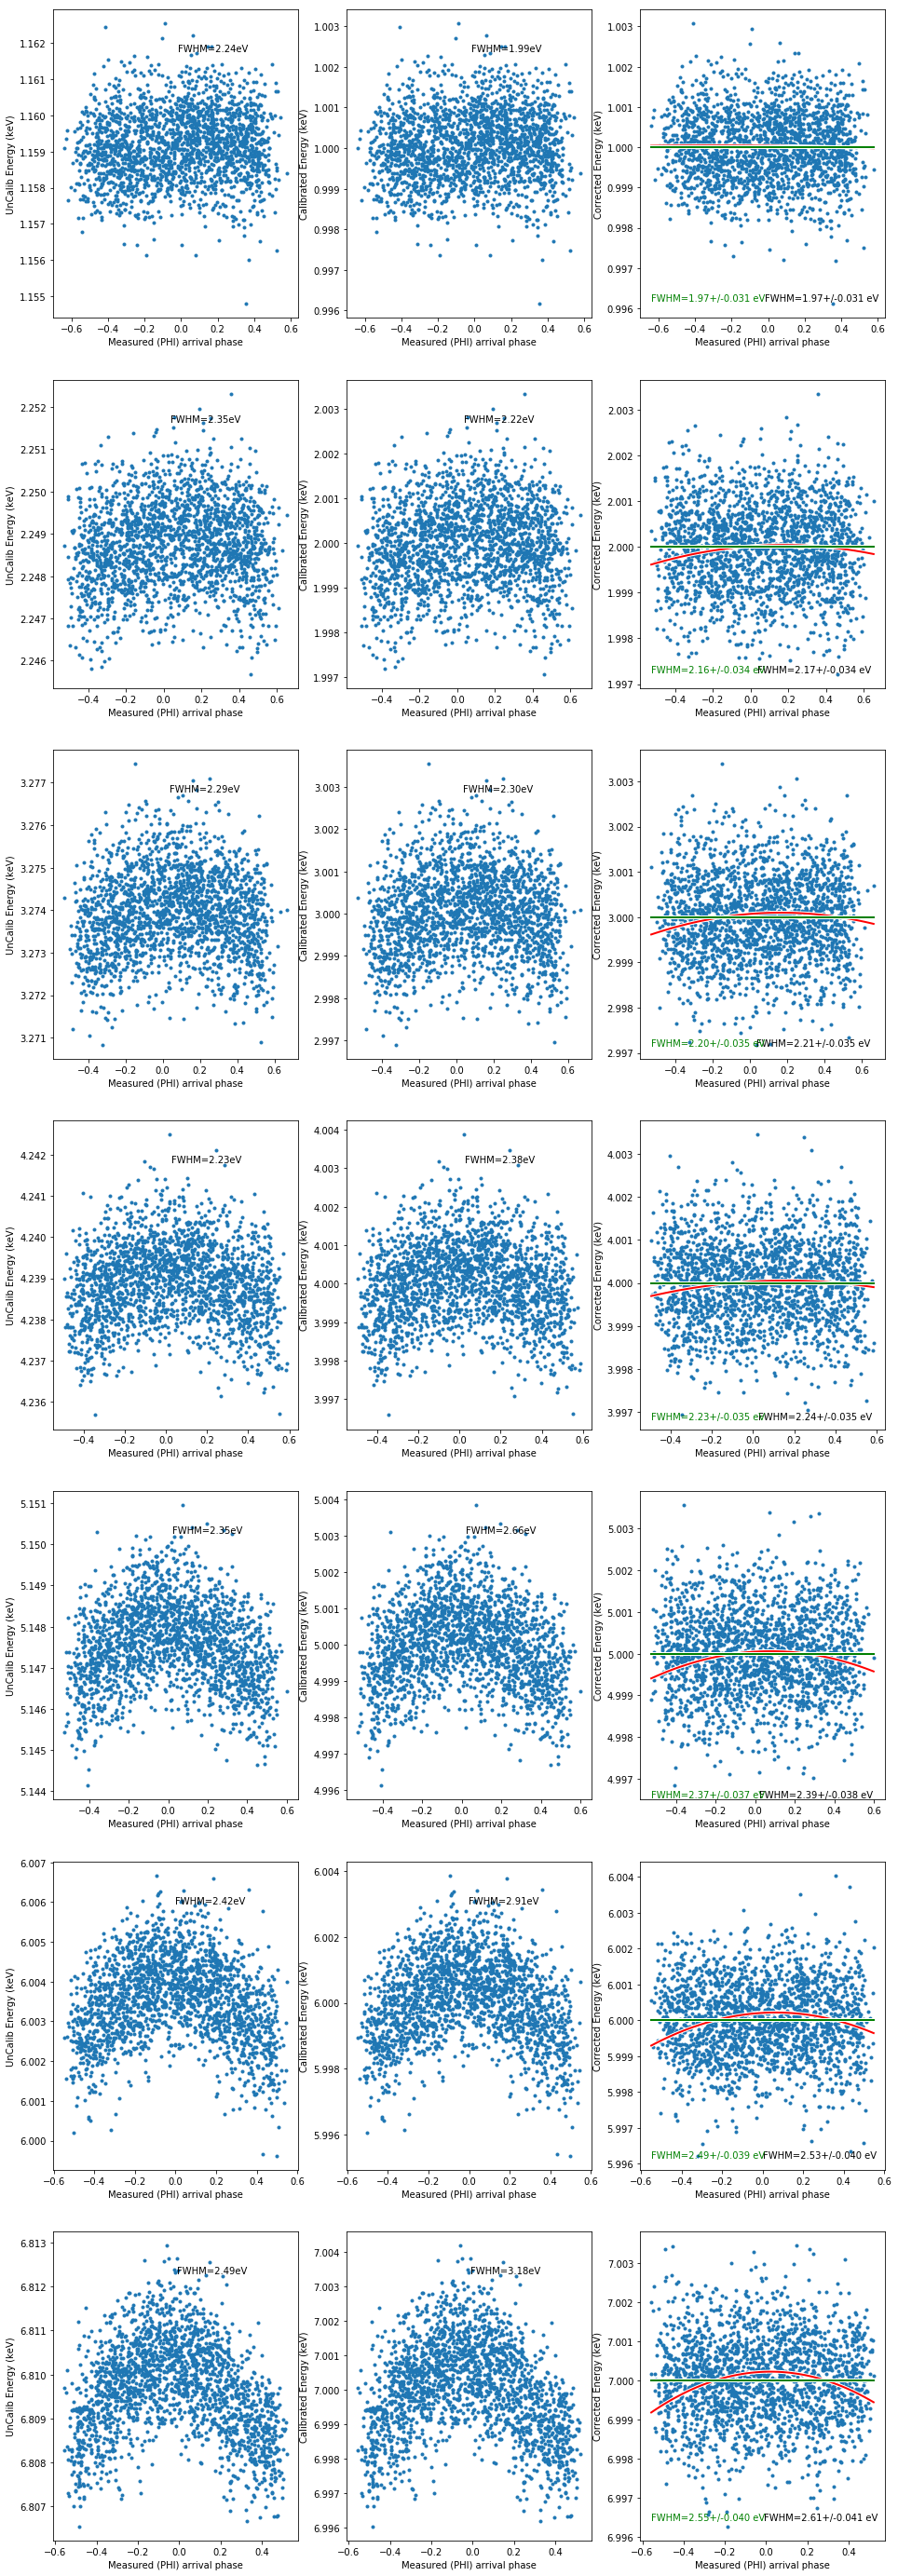

In [21]:
print("Correcting energies for ", tpulses, "pulses with bbfb=", bbfb, "and samprate=",samprate)
ph_test = np.zeros((len(test_keV),tpulses-1))
phase_test = np.zeros((len(test_keV),tpulses-1))
PHI_test = np.zeros((len(test_keV),tpulses-1))
corrE = np.zeros((len(test_keV),tpulses-1))

fig = plt.figure(figsize=(16,50))
irws = len(test_keV)
for i in range(0,len(test_keV)):
    # Detected uncal events
    uncal = fits.open(test_evtFs[i], memmap=True)
    uncalTab = uncal[1].data
    uncalEners = uncalTab['SIGNAL']
    uncal.close()
    # Detected cal events
    cal = fits.open(test_calibFs[i], memmap=True)
    calTab = cal[1].data
    calEners = calTab['SIGNAL']
    cal.close()
    
    # Arrival Phases & Corrected energies
    arrPhase = auxpy.arrivalPhase(impF=test_impFs[i], evtF=test_evtFs[i],samprate=samprate, arrmethod=5)
    relErr = (uncalEners - test_keV[i])*100./test_keV[i]
    fwhmUnCal = 'FWHM={0:0.2f}eV'.format(2.35*np.std(uncalEners)*1000) # eV
    fwhmCal = 'FWHM={0:0.2f}eV'.format(2.35*np.std(calEners)*1000) # eV
    
    # Plot Corr UnCalE vs ArrPhse
    figstr = str(irws)+"3"+str(3*i+1)
    #ax = fig.add_subplot(figstr)
    ax=plt.subplot2grid((irws,3),(i,0))
    ax.set_xlabel("Measured (PHI) arrival phase")
    ax.set_ylabel("UnCalib Energy (keV)")
    #ax.plot(arrPhaseCorr, uncalEners, marker='o', linestyle='none', ms=3)
    ax.plot(arrPhase, uncalEners, marker='o', linestyle='none', ms=3)
    #ileft = np.where(arrPhase<0.4)
    #xleft = arrPhase[ileft]
    #yleft = uncalEners[ileft]
    #fpar1 = Polynomial.fit(xleft,yleft,2)
    #c1,b1,a1 = fpar1.convert(domain=(-1, 1))
    #iright = np.where(arrPhase>0.6)
    #xright = arrPhase[iright]
    #yright = uncalEners[iright]
    #fpar2 = Polynomial.fit(xright,yright,2)
    #c2,b2,a2 = fpar2.convert(domain=(-1, 1))
    
    #xs = np.linspace(np.min(arrPhase),0.5,50)
    #ax.plot(xs,fpar1(xs), linestyle='-', color='red', linewidth=2)
    #xs = np.linspace(0.5,np.max(arrPhase),50)
    #ax.plot(xs,fpar2(xs), linestyle='-', color='red', linewidth=2)
    #crosspt = (-(b1-b2)+np.sqrt((b1-b2)**2 - 4*(a1-a2)*(c1-c2)))/(2*(a1-a2))
    #print("crosspt=",crosspt)
    
    #arrPhaseCorr = recentre_offset(arrPhase, crosspt, arrMeth, bbfb) 
    #corrE = np.polynomial.polynomial.polyval2d(uncalEners, arrPhaseCorr,coeffs)
    corrE = np.polynomial.polynomial.polyval2d(uncalEners, arrPhase,coeffs)
    fwhmCorr = 2.35*np.std(corrE)*1000. # eV
    fwhmCorr_err = fwhmCorr/np.sqrt(2*tpulses-2)
    fwhmCorrStr = 'FWHM={:0.2f}+/-{:0.3f} eV'.format(fwhmCorr, fwhmCorr_err) # eV

    #arrPhaseMid = (np.max(arrPhaseCorr)-abs(np.min(arrPhaseCorr)))/2.
    arrPhaseMid = (np.max(arrPhase)-abs(np.min(arrPhase)))/2.
    xl = 0.55 * arrPhaseMid # xpos for label for FWHM annotation
    yl = np.min(uncalEners) + 0.9 * (np.max(uncalEners)-np.min(uncalEners))
    ax.annotate(fwhmUnCal, xy=(xl,yl))
    
    # Plot Corr CalE vs ArrPhse
    figstr = str(irws)+"3"+str(3*i+2)
    #ax = fig.add_subplot(figstr)
    ax=plt.subplot2grid((irws,3),(i,1))
    ax.set_xlabel("Measured (PHI) arrival phase")
    ylabel="Calibrated Energy (keV)"
    ax.set_ylabel(ylabel)
    #ax.plot(arrPhaseCorr, calEners, marker='o', linestyle='none', ms=3)
    ax.plot(arrPhase, calEners, marker='o', linestyle='none', ms=3)
    yl = np.min(calEners) + 0.9 * (np.max(calEners)-np.min(calEners))
    ax.annotate(fwhmCal, xy=(xl,yl))
    
    # Plot Corr CorrE vs ArrPhse
    figstr = str(irws)+"3"+str(3*i+3)
    #ax = fig.add_subplot(figstr)
    ax=plt.subplot2grid((irws,3),(i,2))
    ax.set_xlabel("Measured (PHI) arrival phase")
    ax.set_ylabel("Corrected Energy (keV)")
    #ax.plot(arrPhase, corrE, marker='o', linestyle='none', ms=3)
    yl = np.min(corrE) + 0.01 * (np.max(corrE)-np.min(corrE))
    ax.annotate(fwhmCorrStr, xy=(xl,yl))
    
    # plot initial polynomial fit
    fpol = Polynomial.fit(arrPhase,corrE,2)
    corrEcorr = test_keV[i]+corrE-fpol(arrPhase)
    ax.plot(arrPhase, corrEcorr, marker='o', linestyle='none', ms=3)
    xs = np.linspace(np.min(arrPhase),np.max(arrPhase),50)
    ax.plot(xs,fpol(xs), linestyle='-', color='white', linewidth=4)
    ax.plot(xs,fpol(xs), linestyle='-', color='red', linewidth=2)
    
    # plot secondary polynomial fit
    fpol2 = Polynomial.fit(arrPhase,corrEcorr,2)
    ax.plot(xs,fpol2(xs), linestyle='-', color='white', linewidth=4)
    ax.plot(xs,fpol2(xs), linestyle='-', color='green', linewidth=2)
    fwhmCorr2 = 2.35*np.std(corrEcorr)*1000. # eV
    fwhmCorr2_err = fwhmCorr2/np.sqrt(2*tpulses-2)
    fwhmCorr2Str = 'FWHM={:0.2f}+/-{:0.3f} eV'.format(fwhmCorr2, fwhmCorr2_err) # eV
    xl2 = np.min(arrPhase)
    ax.annotate(fwhmCorr2Str, xy=(xl2,yl), color="green")

## Comments
* Si los coefficientes se calculan con los offsets iniciales, la corrección es peor que si se calculan con los offset "arreglados"
* no hay diferencia entre calcular los coeficientes con las energías calibradas o no calibradas
* Probar a calcular coeficientes con más de 50 puntos => con 100 o 1000 puntos sale parecido...
* IMPRESCINDIBLE librerías de 20000 plss

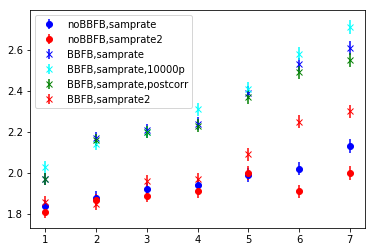

In [24]:
fwhm_smprt=(1.84,1.88,1.92,1.94,1.99,2.02,2.13)
err_smprt=(0.029,0.030,0.030,0.031,0.032,0.032,0.034)
fwhm_smprt2=(1.81,1.87,1.89,1.91,2.00,1.91,2.00)
err_smprt2=(0.029,0.029,0.030,0.030,0.032,0.030,0.032)
fwhm_bbfb_smprt=(1.97, 2.17, 2.21, 2.24, 2.39, 2.53, 2.61) # 2000p
err_bbfb_smprt=(0.031, 0.034, 0.035, 0.035, 0.038, 0.040, 0.041)
fwhm_bbfb_smprt2=(1.86, 1.85, 1.96, 1.97, 2.09, 2.25, 2.30)
err_bbfb_smprt2=(0.029, 0.029, 0.031, 0.031, 0.033, 0.036, 0.036)
plt.errorbar(test_keV,fwhm_smprt,yerr=err_smprt,linestyle='none',fmt='o',color='blue',label='noBBFB,samprate')
plt.errorbar(test_keV,fwhm_smprt2,yerr=err_smprt2,linestyle='none',fmt='o',color='red',label='noBBFB,samprate2')
plt.errorbar(test_keV,fwhm_bbfb_smprt,yerr=err_smprt,linestyle='none',fmt='x',color='blue',label='BBFB,samprate')

fwhm_bbfb_smprt=(2.03, 2.14, 2.20, 2.31, 2.41, 2.58, 2.71) # 10000p
err_bbfb_smprt=(0.014, 0.015, 0.016, 0.016, 0.017, 0.018, 0.019)
plt.errorbar(test_keV,fwhm_bbfb_smprt,yerr=err_smprt,linestyle='none',fmt='x',color='cyan',label='BBFB,samprate,10000p')
fwhm_bbfb_smprt=(1.97, 2.16, 2.20, 2.23, 2.37, 2.49, 2.55) # 2000p
err_bbfb_smprt=(0.031, 0.034, 0.035, 0.035, 0.037, 0.039, 0.040)
plt.errorbar(test_keV,fwhm_bbfb_smprt,yerr=err_smprt,linestyle='none',fmt='x',color='green',label='BBFB,samprate,postcorr')

plt.errorbar(test_keV,fwhm_bbfb_smprt2,yerr=err_smprt2,linestyle='none',fmt='x',color='red',label='BBFB,samprate2')
plt.legend()
plt.show()